In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/

/content/drive/MyDrive/Github


In [3]:
!git clone --branch main https://github.com/jaysulk/PINO_Applications

Cloning into 'PINO_Applications'...
remote: Enumerating objects: 1135, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 1135 (delta 62), reused 90 (delta 40), pack-reused 1018
Receiving objects: 100% (1135/1135), 514.91 MiB | 17.24 MiB/s, done.
Resolving deltas: 100% (800/800), done.
Updating files: 100% (99/99), done.


In [4]:
%cd /content/drive/MyDrive/Github/PINO_Applications

/content/drive/MyDrive/Github/PINO_Applications


In [5]:
#!git branch

In [6]:
#!git fetch origin

In [7]:
#%cat models/basics.py

In [8]:
!pip install functorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
!pip install Mat73

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib notebook
from argparse import ArgumentParser
import yaml
import os
import math
import torch
# from torch import vmap
from functorch import vmap, grad
from models import FNN2d
from train_utils import Adam
# from train_utils.datasets import BurgersLoader
# from train_utils.train_2d import train_2d_burger
# from train_utils.eval_2d import eval_burgers

from solver.WaveEq import WaveEq1D
import traceback

import scipy.io
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import imageio


from tqdm import tqdm
from train_utils.utils import save_checkpoint, load_checkpoint, update_config, load_config
from train_utils.losses import LpLoss
from train_utils.datasets import DataLoader1D

from solver.my_random_fields import GRF_Mattern

from importlib import reload

try:
    import wandb
except ImportError:
    wandb = None

In [11]:
def FDM_Wave(u, D=1, c=1.0):
    batchsize = u.size(0)
    nt = u.size(1)
    nx = u.size(2)

    u = u.reshape(batchsize, nt, nx)
    dt = D / (nt-1)
    dx = D / (nx)

    u_h = torch.fft.fft(u, dim=2)
    # Wavenumbers in y-direction
    k_max = nx//2
    k_x = torch.cat((torch.arange(start=0, end=k_max, step=1, device=u.device),
                     torch.arange(start=-k_max, end=0, step=1, device=u.device)), 0).reshape(1,1,nx)
    ux_h = 2j *np.pi*k_x*u_h
    uxx_h = 2j *np.pi*k_x*ux_h
    ux = torch.fft.irfft(ux_h[:, :, :k_max+1], dim=2, n=nx)
    uxx = torch.fft.irfft(uxx_h[:, :, :k_max+1], dim=2, n=nx)
    ut = (u[:, 2:, :] - u[:, :-2, :]) / (2 * dt)
    utt = (u[:, 2:, :] - 2.0*u[:, 1:-1, :] + u[:, :-2, :]) / (dt**2)
    Du = utt - c**2 * uxx[:,1:-1,:]
    return Du


def PINO_loss_wave(u, u0, c=1.0):
    batchsize = u.size(0)
    nt = u.size(1)
    nx = u.size(2)

    u = u.reshape(batchsize, nt, nx)
    # lploss = LpLoss(size_average=True)

    index_t = torch.zeros(nx,).long()
    index_x = torch.tensor(range(nx)).long()
    boundary_u = u[:, index_t, index_x]
    loss_u = F.mse_loss(boundary_u, u0)

    Du = FDM_Wave(u, c=c)[:, :, :]
    f = torch.zeros(Du.shape, device=u.device)
    loss_f = F.mse_loss(Du, f)

    # loss_bc0 = F.mse_loss(u[:, :, 0], u[:, :, -1])
    # loss_bc1 = F.mse_loss((u[:, :, 1] - u[:, :, -1]) /
    #                       (2/(nx)), (u[:, :, 0] - u[:, :, -2])/(2/(nx)))
    return loss_u, loss_f

In [12]:
def train_wave(model,
               train_loader,
               optimizer, 
               scheduler,
               config,
               rank=0, 
               log=False,
               project='PINO-2d-default',
               group='default',
               tags=['default'],
               use_tqdm=True):
    if rank == 0 and wandb and log:
        run = wandb.init(project=project,
                         entity='shawngr2',
                         group=group,
                         config=config,
                         tags=tags, reinit=True,
                         settings=wandb.Settings(start_method="fork"))

    data_weight = config['train']['xy_loss']
    f_weight = config['train']['f_loss']
    ic_weight = config['train']['ic_loss']
    c = config['data']['c']
    ckpt_freq = config['train']['ckpt_freq']
    model.train()
    myloss = LpLoss(size_average=True)
    pbar = range(config['train']['epochs'])
    if use_tqdm:
        pbar = tqdm(pbar, dynamic_ncols=True, smoothing=0.1)

    for e in pbar:
        model.train()
        train_pino = 0.0
        data_l2 = 0.0
        train_ic = 0.0
        train_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(rank), y.to(rank)
#             display(x.shape, y.shape)
            out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)

            loss_ic, loss_f = PINO_loss_wave(out, x[:, 0, :, 0], c=c)
            total_loss = loss_ic * ic_weight + loss_f * f_weight + data_loss * data_weight

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            data_l2 += data_loss.item()
            train_pino += loss_f.item()
            train_loss += total_loss.item()
            train_ic += loss_ic.item()
        scheduler.step()
        data_l2 /= len(train_loader)
        train_pino /= len(train_loader)
        train_loss /= len(train_loader)
        if use_tqdm:
            pbar.set_description(
                (
                    f'Epoch {e}, train loss: {train_loss:.5f} '
                    f'train f error: {train_pino:.5f}; '
                    f'data l2 error: {data_l2:.5f}; '
                    f'train ic error: {train_ic:.5f}'
                )
            )
        if wandb and log:
            wandb.log(
                {
                    'Train f error': train_pino,
                    'Train L2 error': data_l2,
                    'Train ic error': loss_ic,
                    'Train loss': train_loss,
                }
            )

        if e % ckpt_freq == 0:
            save_checkpoint(config['train']['save_dir'],
                            config['train']['save_name'].replace('.pt', f'_{e}.pt'),
                            model, optimizer)
    save_checkpoint(config['train']['save_dir'],
                    config['train']['save_name'],
                    model, optimizer)
    print('Done!')

In [13]:
def eval_wave(model,
              dataloader,
              config,
              device,
              use_tqdm=True):
    model.eval()
    myloss = LpLoss(size_average=True)
    c = config['data']['c']
    if use_tqdm:
        pbar = tqdm(dataloader, dynamic_ncols=True, smoothing=0.05)
    else:
        pbar = dataloader

    test_err = []
    f_err = []

    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        out = model(x).reshape(y.shape)
        data_loss = myloss(out, y)

        loss_u, f_loss = PINO_loss_wave(out, x[:, 0, :, 0], c=c)
        test_err.append(data_loss.item())
        f_err.append(f_loss.item())

    mean_f_err = np.mean(f_err)
    std_f_err = np.std(f_err, ddof=1) / np.sqrt(len(f_err))

    mean_err = np.mean(test_err)
    std_err = np.std(test_err, ddof=1) / np.sqrt(len(test_err))

    print(f'==Averaged relative L2 error mean: {mean_err}, std error: {std_err}==\n'
          f'==Averaged equation error mean: {mean_f_err}, std error: {std_f_err}==')

In [14]:
config_file = 'configs/custom/wave-0000.yaml'
config = load_config(config_file)
display(config)

{'data': {'name': 'Wave-0000',
  'total_num': 1000,
  'n_train': 900,
  'n_test': 100,
  'nx': 4096,
  'nt': 100,
  'sub': 32,
  'sub_t': 1,
  'c': 1.0},
 'model': {'layers': [16, 24, 24, 32, 32],
  'modes1': [15, 12, 9, 9],
  'modes2': [15, 12, 9, 9],
  'fc_dim': 128,
  'activation': 'gelu'},
 'train': {'batchsize': 20,
  'epochs': 500,
  'milestones': [150, 300, 450],
  'base_lr': 0.001,
  'scheduler_gamma': 0.5,
  'ic_loss': 5.0,
  'f_loss': 1.0,
  'xy_loss': 10.0,
  'save_dir': 'Wave',
  'save_name': 'Wave-eqn.pt',
  'ckpt': 'checkpoints/Wave/Wave-eqn.pt',
  'ckpt_freq': 100},
 'log': {'project': 'PINO-Wave', 'group': 'Wave-0000'},
 'test': {'batchsize': 1, 'ckpt': 'checkpoints/Wave/Wave-eqn.pt'}}

In [15]:
Nsamples = config['data']['total_num']
N = config['data']['nx']
Nt0 = config['data']['nt']
c = config['data']['c']
sub_x = config['data']['sub']
sub_t = config['data']['sub_t']
Nx = N // sub_x
Nt = Nt0 // sub_t + 1
dim = 1
l = 0.1
L = 1.0
sigma = 0.2 #2.0
Nu = None # 2.0
dt = 1.0e-4
tend = 1.0
save_int = int(tend/dt/Nt)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
grf = GRF_Mattern(dim, N, length=L, nu=Nu, l=l, sigma=sigma, boundary="periodic", device=device)
U0 = grf.sample(Nsamples)

In [17]:
wave_eq = WaveEq1D(Nx=N, c=c, dt=dt, device=device)
U = vmap(wave_eq.wave_driver, in_dims=(0, None))(U0, save_int)

In [18]:
a = U0.cpu().float()
u = U.cpu().float()

display(u.shape,a.shape)

torch.Size([1000, 102, 4096])

torch.Size([1000, 4096])

In [19]:
dataset = DataLoader1D(a, u, config['data']['nx'], config['data']['nt'], config['data']['sub'], config['data']['sub_t'])
train_loader = dataset.make_loader(config['data']['n_train'], config['train']['batchsize'], start=0, train=True)
test_loader = dataset.make_loader(config['data']['n_test'], config['test']['batchsize'], start=config['data']['n_train'], train=False)

In [20]:
log = False
model = FNN2d(modes1=config['model']['modes1'],
                  modes2=config['model']['modes2'],
                  fc_dim=config['model']['fc_dim'],
                  layers=config['model']['layers'],
                  activation=config['model']['activation']).to(device)

optimizer = Adam(model.parameters(), betas=(0.9, 0.999),lr=config['train']['base_lr'])
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                 milestones=config['train']['milestones'],
                                                 gamma=config['train']['scheduler_gamma'])

In [21]:
#load_checkpoint(model, ckpt_path=config['train']['ckpt'], optimizer=None)

In [22]:
train_wave(model,
           train_loader,
           optimizer,
           scheduler,
           config,
           rank=0,
           log=log,
           project=config['log']['project'],
           group=config['log']['group'])

Epoch 0, train loss: 10.40489 train f error: 0.27985; data l2 error: 1.00877; train ic error: 0.33624:   0%|          | 1/500 [00:12<1:41:52, 12.25s/it]

Checkpoint is saved at checkpoints/Wave/Wave-eqn_0.pt


Epoch 100, train loss: 0.14326 train f error: 0.05825; data l2 error: 0.00850; train ic error: 0.00002:  20%|██        | 101/500 [05:26<20:55,  3.15s/it]

Checkpoint is saved at checkpoints/Wave/Wave-eqn_100.pt


Epoch 200, train loss: 0.13308 train f error: 0.06091; data l2 error: 0.00722; train ic error: 0.00002:  40%|████      | 201/500 [10:41<15:43,  3.16s/it]

Checkpoint is saved at checkpoints/Wave/Wave-eqn_200.pt


Epoch 300, train loss: 0.09859 train f error: 0.06520; data l2 error: 0.00334; train ic error: 0.00001:  60%|██████    | 301/500 [15:57<10:32,  3.18s/it]

Checkpoint is saved at checkpoints/Wave/Wave-eqn_300.pt


Epoch 400, train loss: 0.09369 train f error: 0.06886; data l2 error: 0.00248; train ic error: 0.00000:  80%|████████  | 401/500 [21:13<05:13,  3.17s/it]

Checkpoint is saved at checkpoints/Wave/Wave-eqn_400.pt


Epoch 499, train loss: 0.08406 train f error: 0.07180; data l2 error: 0.00123; train ic error: 0.00000: 100%|██████████| 500/500 [26:26<00:00,  3.17s/it]

Checkpoint is saved at checkpoints/Wave/Wave-eqn.pt
Done!


In [23]:
eval_wave(model, test_loader, config, device)

100%|██████████| 100/100 [00:00<00:00, 165.48it/s]

==Averaged relative L2 error mean: 0.001313258208683692, std error: 2.7853703611261132e-05==
==Averaged equation error mean: 0.06691484027542174, std error: 0.0036182440800136863==


In [24]:
Nx = config['data']['nx'] // config['data']['sub']
Nt = config['data']['nt'] // config['data']['sub_t'] + 1
Ntest = config['data']['n_test']
model.eval()
test_x = np.zeros((Ntest,Nt,Nx,3))
preds_y = np.zeros((Ntest,Nt,Nx))
test_y = np.zeros((Ntest,Nt,Nx))
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data_x, data_y = data
        data_x, data_y = data_x.to(device), data_y.to(device)
        pred_y = model(data_x).reshape(data_y.shape)
        test_x[i] = data_x.cpu().numpy()
        test_y[i] = data_y.cpu().numpy()
        preds_y[i] = pred_y.cpu().numpy()
#     data_loss = myloss(out, y)

In [25]:
key = 1
pred = preds_y[key]
true = test_y[key]


a = test_x[key]
Nt, Nx, _ = a.shape
u0 = a[0,:,0]
T = a[:,:,2]
X = a[:,:,1]
x = X[0]

In [26]:
plt.rcParams.update({'font.size': 11})

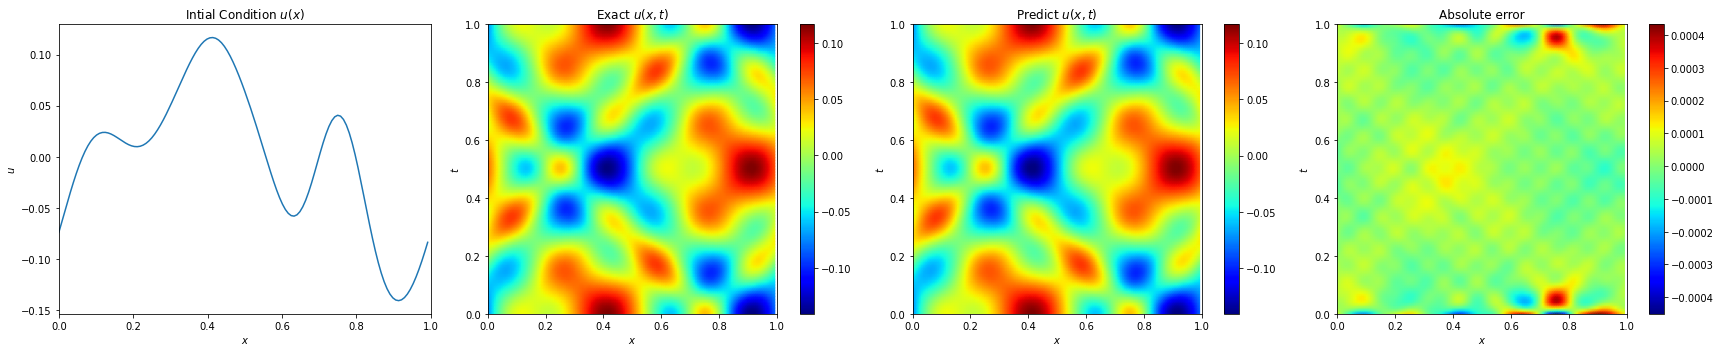

In [27]:
%matplotlib inline
fig = plt.figure(figsize=(24,5))
plt.subplot(1,4,1)

plt.plot(x, u0)
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('Intial Condition $u(x)$')
plt.xlim([0,1])
plt.tight_layout()

plt.subplot(1,4,2)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(X, T, true, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title(f'Exact $u(x,t)$')
plt.tight_layout()
plt.axis('square')

plt.subplot(1,4,3)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(X, T, pred, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title(f'Predict $u(x,t)$')
plt.axis('square')

plt.tight_layout()

plt.subplot(1,4,4)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(X, T, pred - true, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.axis('square')

plt.show()

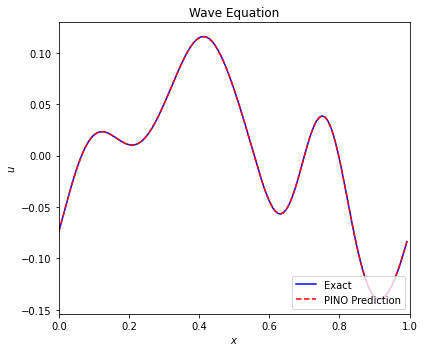

In [28]:
%matplotlib inline
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
ax.plot(x, true[0], 'b-', label='Exact')
ax.plot(x, pred[0], 'r--', label='PINO Prediction')
ylim = plt.ylim()
xlim = [0, 1]
plt.tight_layout()



for i in range(Nt):
    ax.clear()
    ax.plot(x, true[i], 'b-', label='Exact')
    ax.plot(x, pred[i], 'r--', label='PINO Prediction')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel(f'$x$')
    plt.ylabel(f'$u$')
    plt.title(f'Wave Equation')
    plt.legend(loc='lower right')
    plt.tight_layout()
    fig.canvas.draw()

plt.show()

In [29]:
%matplotlib notebook
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
ax.plot(x, true[0], 'b-', label='Exact')
ax.plot(x, pred[0], 'r--', label='PINO Prediction')
ylim = plt.ylim()
xlim = [0, 1]
plt.tight_layout()



for i in range(Nt):
    ax.clear()
    ax.plot(x, true[i], 'b-', label='Exact')
    ax.plot(x, pred[i], 'r--', label='PINO Prediction')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel(f'$x$')
    plt.ylabel(f'$u$')
    plt.title(f'Wave Equation')
    plt.legend(loc='lower right')
    plt.tight_layout()
    fig.canvas.draw()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
def save_data(data_path, test_x, test_y, preds_y):
    data_dir, data_filename = os.path.split(data_path)
    os.makedirs(data_dir, exist_ok=True)
    np.savez(data_path, test_x=test_x, test_y=test_y, preds_y=preds_y)

def load_data(data_path):
    data = np.load(data_path)
    test_x = data['test_x']
    test_y = data['test_y']
    preds_y = data['preds_y']
    return test_x, test_y, preds_y

In [31]:
data_dir = 'data/Wave1D'
data_filename = 'data.npz'
data_path = os.path.join(data_dir, data_filename)
# os.makedirs(data_dir, exist_ok=True)

In [32]:
save_data(data_path, test_x, test_y, preds_y)

In [33]:
test_x, test_y, preds_y = load_data(data_path)

In [34]:
def plot_predictions(key, test_x, test_y, preds_y, print_index=False, save_path=None, font_size=None):
    if font_size is not None:
        plt.rcParams.update({'font.size': font_size})
    pred = preds_y[key]
    true = test_y[key]


    a = test_x[key]
    Nt, Nx, _ = a.shape
    u0 = a[0,:,0]
    T = a[:,:,2]
    X = a[:,:,1]
    x = X[0]

    # Plot
    fig = plt.figure(figsize=(23,5))
    plt.subplot(1,4,1)

    plt.plot(x, u0)
    plt.xlabel('$x$')
    plt.ylabel('$u$')
    plt.title('Intial Condition $u(x)$')
    plt.xlim([0,1])
    plt.tight_layout()

    plt.subplot(1,4,2)
    # plt.pcolor(XX,TT, S_test, cmap='jet')
    plt.pcolormesh(X, T, true, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title(f'Exact $u(x,t)$')
    plt.tight_layout()
    plt.axis('square')

    plt.subplot(1,4,3)
    # plt.pcolor(XX,TT, S_pred, cmap='jet')
    plt.pcolormesh(X, T, pred, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title(f'Predict $u(x,t)$')
    plt.axis('square')

    plt.tight_layout()

    plt.subplot(1,4,4)
    # plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
    plt.pcolormesh(X, T, pred - true, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title('Absolute Error')
    plt.tight_layout()
    plt.axis('square')

    if save_path is not None:
        plt.savefig(f'{save_path}.png', bbox_inches='tight')
    plt.show()